In [1]:
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.chat_models import ChatOllama
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import tiktoken
import pandas as pd


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
loader = DirectoryLoader('data', glob="**/*.txt")
docs = loader.load()

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [5]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [6]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
counts = [num_tokens_from_string(t) for t in texts]


<function matplotlib.pyplot.show(close=None, block=None)>

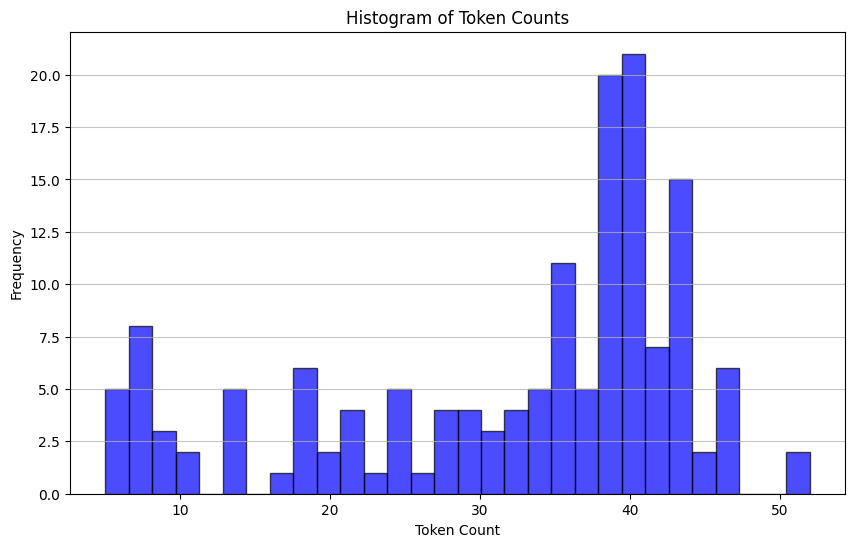

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [9]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 5250


In [10]:
model.encode(texts[0])

array([ 8.17794055e-02, -2.35951360e-04,  2.56860182e-02,  8.81078392e-02,
       -8.03048611e-02, -2.91706342e-02,  4.69834581e-02, -1.29966080e-01,
        1.55319599e-02, -5.90398572e-02, -5.29648289e-02, -9.95867103e-02,
        1.44785130e-02, -1.07123023e-02,  1.47404410e-02, -3.46834771e-02,
        9.30706561e-02,  5.95258363e-03,  9.04418603e-02,  8.36606231e-03,
       -1.08669855e-01, -3.98081839e-02, -6.12060428e-02,  6.53788224e-02,
       -1.08445995e-02, -3.86610962e-02, -2.04489706e-03,  6.54030070e-02,
       -6.35498241e-02, -3.94053720e-02,  5.81809506e-02,  5.94850890e-02,
        6.67143911e-02,  1.05736339e-02, -3.13485861e-02,  7.16229752e-02,
        9.23216809e-04, -1.27589688e-01, -4.98465411e-02, -1.39218196e-03,
        3.18854451e-02,  3.39955576e-02,  2.64611151e-02,  7.66845495e-02,
       -2.61221901e-02, -2.05071978e-02, -5.53927086e-02, -1.84725635e-02,
        2.55853608e-02, -4.51512933e-02, -6.32999241e-02,  1.70028787e-02,
       -8.30871388e-02, -

In [11]:
global_embeddings = [model.encode(txt) for txt in texts]

In [12]:
global_embeddings

[array([ 8.17794055e-02, -2.35951360e-04,  2.56860182e-02,  8.81078392e-02,
        -8.03048611e-02, -2.91706342e-02,  4.69834581e-02, -1.29966080e-01,
         1.55319599e-02, -5.90398572e-02, -5.29648289e-02, -9.95867103e-02,
         1.44785130e-02, -1.07123023e-02,  1.47404410e-02, -3.46834771e-02,
         9.30706561e-02,  5.95258363e-03,  9.04418603e-02,  8.36606231e-03,
        -1.08669855e-01, -3.98081839e-02, -6.12060428e-02,  6.53788224e-02,
        -1.08445995e-02, -3.86610962e-02, -2.04489706e-03,  6.54030070e-02,
        -6.35498241e-02, -3.94053720e-02,  5.81809506e-02,  5.94850890e-02,
         6.67143911e-02,  1.05736339e-02, -3.13485861e-02,  7.16229752e-02,
         9.23216809e-04, -1.27589688e-01, -4.98465411e-02, -1.39218196e-03,
         3.18854451e-02,  3.39955576e-02,  2.64611151e-02,  7.66845495e-02,
        -2.61221901e-02, -2.05071978e-02, -5.53927086e-02, -1.84725635e-02,
         2.55853608e-02, -4.51512933e-02, -6.32999241e-02,  1.70028787e-02,
        -8.3

In [13]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 10
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

array([-0.5352773,  7.585048 , 11.12044  , 12.193706 ,  3.9844954,
        5.980072 ,  2.3034492,  5.154643 ,  2.0142918,  0.6839968],
      dtype=float32)

In [14]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

In [15]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [42]:
_

14

In [16]:
simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text  \
0  Step into our Tuscan-inspired sanctuary, where...   
1  Tuscany, renowned for its breathtaking country...   
2  Begin your journey with an antipasto platter a...   

                                           Embedding  Cluster  
0  [-0.5352773, 7.585048, 11.12044, 12.193706, 3....        4  
1  [-0.5953118, 7.6574554, 11.036981, 12.13103, 4...        4  
2  [-0.6575814, 7.381995, 10.9170885, 12.157673, ...        4  


In [17]:
df.Cluster.unique()

array([ 4,  5,  7, 14, 11, 10,  0,  1, 12, 16,  8, 15, 17,  6,  2,  3,  9,
       13], dtype=int64)

In [18]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [19]:
clustered_texts = format_cluster_texts(df)

In [20]:
clustered_texts

{4: 'Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany, --- Tuscany, renowned for its breathtaking countryside and rich culinary heritage, offers a bounty of flavors and traditions to explore. --- Begin your journey with an antipasto platter adorned with cured meats, aged cheeses, and marinated vegetables, reminiscent of leisurely gatherings under the Tuscan sun. Each bite tells a story of --- Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul, --- both body and soul, offering a taste of Tuscan tradition with every spoonful. --- As you dine, let the flavors of Tuscany transport you to a simpler time, where meals were savored slowly and each ingredient was cherished for its role in creating culinar

In [26]:
from langchain_community.chat_models import ChatOllama
model1 = ChatOllama(temperature=0, model='llama3.1')

In [27]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model1 | StrOutputParser()

In [24]:
from tqdm import tqdm

In [28]:
summaries = {}
for cluster, text in tqdm(clustered_texts.items()):
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary


100%|██████████| 18/18 [02:54<00:00,  9.70s/it]


In [29]:
summaries

{4: "Here is a detailed summary of the text:\n\n**Summary**\n\nThe text invites readers to experience a Tuscan-inspired dining experience, where the warm colors and aromas of Tuscany's countryside set the stage for a memorable meal. The journey begins with an antipasto platter featuring cured meats, cheeses, and marinated vegetables, reminiscent of leisurely gatherings in the Tuscan sun.\n\n**Key Features**\n\n* A focus on traditional Tuscan cuisine, highlighting its rich flavors and heritage\n* A menu that includes classic dishes such as Ribollita (a hearty vegetable soup with cannellini beans and Tuscan kale)\n* Emphasis on the connection between food, land, and tradition in Tuscan cuisine\n* A description of the dining experience as a journey through time, where meals are savored slowly and each ingredient is cherished for its role in creating culinary magic\n\n**Key Themes**\n\n* The importance of tradition and heritage in Tuscan cuisine\n* The connection between food, land, and cu

In [30]:
embedded_summaries = [model.encode(summary) for summary in summaries.values()]

In [31]:
embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [32]:
simple_labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    
    clustered_summaries[label].append(list(summaries.values())[i])

In [34]:
clustered_summaries

{0: ["Here is a detailed summary of the text:\n\n**Summary**\n\nThe text invites readers to experience a Tuscan-inspired dining experience, where the warm colors and aromas of Tuscany's countryside set the stage for a memorable meal. The journey begins with an antipasto platter featuring cured meats, cheeses, and marinated vegetables, reminiscent of leisurely gatherings in the Tuscan sun.\n\n**Key Features**\n\n* A focus on traditional Tuscan cuisine, highlighting its rich flavors and heritage\n* A menu that includes classic dishes such as Ribollita (a hearty vegetable soup with cannellini beans and Tuscan kale)\n* Emphasis on the connection between food, land, and tradition in Tuscan cuisine\n* A description of the dining experience as a journey through time, where meals are savored slowly and each ingredient is cherished for its role in creating culinary magic\n\n**Key Themes**\n\n* The importance of tradition and heritage in Tuscan cuisine\n* The connection between food, land, and c

In [35]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [36]:
final_summaries

{0: "It seems like there's been a mistake. The text you provided doesn't seem to be related to dishes or food recipes, but rather a narrative about Giovanni and his culinary journey.\n\nHowever, I can try to summarize the key points from the text:\n\n* Giovanni believes that food is not just about sustenance, but also about connection, community, and shared experiences.\n* He is dedicated to supporting and nurturing the vibrant tapestry of food culture in his city.\n* Giovanni's greatest source of pride is the legacy he is building for his own family, passing down traditions, recipes, and values to future generations.\n* The passage highlights the importance of tradition, creativity, community, and legacy in the culinary world.\n\nIf you'd like to provide a different text related to dishes or food recipes, I'd be happy to assist you with summarizing it."}

In [37]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [38]:
combined_texts

['Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany,',
 'Tuscany, renowned for its breathtaking countryside and rich culinary heritage, offers a bounty of flavors and traditions to explore.',
 'Begin your journey with an antipasto platter adorned with cured meats, aged cheeses, and marinated vegetables, reminiscent of leisurely gatherings under the Tuscan sun. Each bite tells a story of',
 'tells a story of generations past, of farmers and artisans who have perfected their craft over centuries.',
 'Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul,',
 'both body and soul, offering a taste of Tuscan tradition with every spoonful.',
 'Alternatively, savor the simplicity of Cacciucco, a rustic seafo

In [39]:
from pinecone import Pinecone, ServerlessSpec
from langchain_community.retrievers import PineconeHybridSearchRetriever

In [40]:
pc = Pinecone(api_key='d7204d21-cb62-4544-b49c-9169b420c0e1')

In [41]:
index_name = 'sbert-50dim'

In [ ]:
pc.create_index(name=index_name,dimension=384,metric="dotproduct",spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"))

In [48]:
from pinecone_text.sparse import BM25Encoder

In [49]:
bm25encoder = BM25Encoder()

In [50]:
bm25encoder.fit(combined_texts)

  0%|          | 0/171 [00:00<?, ?it/s]

In [42]:
index =pc.Index(index_name)

In [44]:
from langchain_huggingface import HuggingFaceEmbeddings

In [43]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [45]:
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [46]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
retriever = PineconeHybridSearchRetriever(
    embeddings= embeddings, sparse_encoder=bm25encoder, index=index,top_k=  8
)

In [ ]:
retriever.add_texts(combined_texts)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
query = 'Who is the owner of the restaurant'

In [ ]:
print(num_tokens_from_string(text))

9633


In [ ]:
def expand_query(query):
    words = query.split()
    expanded_words = []

    for word in words:
        synonyms = wordnet.synsets(word)
        lemmas = set()

        for syn in synonyms:
            for lemma in syn.lemmas():
                lemmas.add(lemma.name())

        if lemmas:
            expanded_words.append(f"({word} OR {' OR '.join(lemmas)})")
        else:
            expanded_words.append(word)

    return ' '.join(expanded_words)

In [52]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model1
    | StrOutputParser()
)

In [53]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")

'The owner of the restaurant is Giovanni.'

## Building ChatBot

In [54]:
import gradio as gr

In [55]:
## to modify

def chatfunction(text_box,history):
    querry = text_box
    querry = expanded_query(querry)
    response_text = rag_chain.invoke(querry)

    return response_text

In [56]:
gr.ChatInterface(fn =chatfunction, textbox= gr.Textbox(placeholder= " enter message here"),
                 chatbot= gr.Chatbot()).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [59]:
import nltk
from nltk.corpus import wordnet

# Download necessary NLTK data (if not already downloaded)


# Function to expand query
def expand_query(query):
    words = query.split()
    expanded_words = []

    for word in words:
        synonyms = wordnet.synsets(word)
        lemmas = set()

        for syn in synonyms:
            for lemma in syn.lemmas():
                lemmas.add(lemma.name())

        if lemmas:
            expanded_words.append(f"({word} OR {' OR '.join(lemmas)})")
        else:
            expanded_words.append(word)

    return ' '.join(expanded_words)

# Original query
query = "Who is the owner of the dining venue?"
expanded_query = expand_query(query)

# Print the expanded query
print(expanded_query)

(Who OR WHO OR World_Health_Organization) (is OR equal OR cost OR personify OR make_up OR represent OR follow OR embody OR constitute OR exist OR comprise OR live OR be) the (owner OR owner OR possessor OR proprietor) of the (dining OR din OR dine OR dining OR boom) venue?


NameError: name 'expanded_query' is not defined